In [2]:
import argparse
import json
from pathlib import Path
import random
import os
#import schedulefree

import numpy as np
import torch
import wandb

import config
from data.utils import DataReader, get_dataset
import distributed
from models.utils import get_model
from optim.base import train
from optim.utils import cos_inf_schedule, wsd_schedule, get_batch

import sys

if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]
    
def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument(
        "--config_format", default="base", choices=config.registered_formats()
    )
    args, rem_args = parser.parse_known_args()
    args.n_layer=12
    args.n_head=12
    args.n_embd=768
    args.datasets_dir = "/mntcephfs/lab_data/chenyupeng/llm_datasets"
    return config.parse_args_with_format(
        format=args.config_format, base_parser=parser, args=rem_args, namespace=args
    )

/mntcephfs/lab_data/wangsenmiao/anaconda/olmo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = get_args()

In [4]:
args.config_format

'base'

In [5]:
import copy

In [6]:

def get_data_readers(args, verbose=True):
    data_srcs = get_dataset(args)
    train_reader = DataReader(
        data_src=data_srcs["train"],
        batch_size=args.batch_size,
        sequence_length=args.sequence_length,
        seed=args.data_seed,
        with_replacement=False,
        auto_shard=True,
        keep_in_ram=args.data_in_ram,
    )
    val_reader = DataReader(
        data_src=data_srcs["val"],
        batch_size=args.batch_size,
        sequence_length=args.sequence_length,
        seed=args.data_seed,
        with_replacement=False,
        auto_shard=False,  # NOTE Identical Per Rank
        keep_in_ram=args.data_in_ram,
    )

    if verbose:
        print(f"Num training tokens: {train_reader.num_tokens}")
        print(f"Num validation tokens: {val_reader.num_tokens}")

    return {
        "train": train_reader,
        "val": val_reader,
    }
data = get_data_readers(args)

/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563


In [7]:
data

{'train': <data.utils.DataReader at 0x15544d2110d0>,
 'val': <data.utils.DataReader at 0x1555502fa5d0>}

In [7]:
model = get_model(args)

In [8]:
model

Llama(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x LlamaBlock(
        (ln_1): RMSNorm()
        (attn): LlamaAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): RMSNorm()
        (mlp): LlamaMLP(
          (w1): Linear(in_features=768, out_features=2048, bias=False)
          (w2): Linear(in_features=768, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=768, bias=False)
        )
      )
    )
    (ln_f): RMSNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [10]:
model.state_dict().keys()

odict_keys(['transformer.wte.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.ln_2.weight', 'transformer.h.0.mlp.w1.weight', 'transformer.h.0.mlp.w2.weight', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.1.ln_1.weight', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.ln_2.weight', 'transformer.h.1.mlp.w1.weight', 'transformer.h.1.mlp.w2.weight', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.2.ln_1.weight', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.c_proj.weight', 'transformer.h.2.ln_2.weight', 'transformer.h.2.mlp.w1.weight', 'transformer.h.2.mlp.w2.weight', 'transformer.h.2.mlp.c_proj.weight', 'transformer.h.3.ln_1.weight', 'transformer.h.3.attn.c_attn.weight', 'transformer.h.3.attn.c_proj.weight', 'transformer.h.3.ln_2.weight', 'transformer.h.3.mlp.w1.weight', 'transformer.h.3.mlp.w2.weight', 'transformer.h.3.mlp.c_proj.weight'

In [11]:
model.lm_head.weight

Parameter containing:
tensor([[ 0.0089, -0.0110,  0.0234,  ...,  0.0059,  0.0297, -0.0362],
        [ 0.0162,  0.0144,  0.0173,  ...,  0.0190,  0.0007,  0.0192],
        [ 0.0129, -0.0223, -0.0095,  ..., -0.0226,  0.0007, -0.0421],
        ...,
        [-0.0024,  0.0331,  0.0030,  ..., -0.0057,  0.0069, -0.0274],
        [-0.0095, -0.0012,  0.0162,  ...,  0.0222, -0.0094, -0.0306],
        [-0.0181, -0.0050,  0.0003,  ...,  0.0324, -0.0095,  0.0064]],
       requires_grad=True)

In [18]:
import copy

def load_ck_state(model, step):
    model_new = copy.deepcopy(model)
    current_ckpt = torch.load(f"/mntcephfs/lab_data/yuyueyao/river_valley_project/llama_100m/slimpajama_llama_nlayers12_nhead12_lr0.001_sched_wsd_warmup300_decay_linear_0.1_iter25000_bs50x2_ws2_seed0_data_seed1337/ckpts/{step}/main.pt",map_location=torch.device('cpu'))
    new_state_dict = {}
    for key, value in current_ckpt["model"].items():
        new_key = key.replace('_orig_mod.', '')  # 移除前缀
        new_key = new_key.replace('module.', '')  # 移除前缀
        new_state_dict[new_key] = value
    model_new.load_state_dict(new_state_dict)
    return model_new 
    
model1 = load_ck_state(model, 3000)
model2 = load_ck_state(model, 4000)
model3 = load_ck_state(model, 5000)
#current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/12000/main.pt",map_location=torch.device('cpu'))


In [21]:
def plot_1D_landscape(step1, step2):
    model1 = load_ck_state(model, step1)
    model2 = load_ck_state(model, step2)
    n_points = 20
    interp_factors = torch.linspace(0, 1, n_points)
    perplexities = []
    
    for i, alpha in enumerate(interp_factors):
        print(f"Processing interpolation point {i+1}/{n_points}, alpha = {alpha:.2f}")
        
        # 插值参数
        interpolated_dict = {key: (1-alpha) * model1.state_dict()[key] + alpha * model2.state_dict()[key]
                             for key in model1.state_dict()}
    
        # 应用插值参数
        interp_model = copy.deepcopy(model)
        interp_model.load_state_dict(interpolated_dict)
        interp_model.eval()
    
        # 计算perplexity
        total_loss = 0
        n_batches = 0
        data = get_data_readers(args)
        interp_model = interp_model.cuda()
        with torch.no_grad():
            for steps in range(10):
                x, y = get_batch(data["val"], device="cpu")
                x = x.cuda()
                y = y.cuda()
                print(f"  Processing batch {steps+1}...")
                outputs = interp_model(x, targets=y, get_logits=True)
                total_loss += outputs["loss"].item()
                n_batches += 1
    
        interp_model = interp_model.cpu()
        perplexity = torch.tensor(total_loss / n_batches)
        perplexities.append(perplexity)
        print(f"  Completed interpolation point {i+1}/{n_points}, loss = {perplexity:.2f}")
    
    from matplotlib import pyplot as plt
    plt.plot(interp_factors.numpy(), perplexities, marker='o')
    plt.xlabel('Interpolation Factor')
    plt.ylabel('Val Loss')
    plt.title(f'Val Loss of Linear Interpolations Between {step1} step and {step2} step')
    plt.savefig(f'/home/wangsenmiao/yupeng_gpt/WSD/jaggi-lr/src/save_file/1d_landscape_{step1}_{step2}.png')
    plt.show()

In [40]:
import matplotlib.pyplot as plt
def plot_2D_landscape(step1,step2,step3):
    import torch
    model1 = load_ck_state(model, step1)
    model2 = load_ck_state(model, step2)
    model3 = load_ck_state(model, step3)
    n_points = 13  # Number of points along each dimension
    interp_factors_x = torch.linspace(-0.2, 1, n_points)  # Interpolation along the x-axis (alpha)
    interp_factors_y = torch.linspace(-0.2, 1, n_points)  # Interpolation along the y-axis (beta)
    loss_landscape = torch.zeros((n_points, n_points))  # To store the loss values
    
    for i, alpha in enumerate(interp_factors_x):
        for j, beta in enumerate(interp_factors_y):
            print(f"Processing interpolation point ({i+1}/{n_points}, {j+1}/{n_points}), alpha = {alpha:.2f}, beta = {beta:.2f}")
            
            # Bilinear interpolation parameters
            interpolated_dict = {
                key: model3.state_dict()[key] + alpha*(model1.state_dict()[key]-model3.state_dict()[key]) 
                    + beta*(model2.state_dict()[key]-model3.state_dict()[key])
                     for key in model1.state_dict()
            }
    
            # Apply interpolated parameters
            interp_model = copy.deepcopy(model)
            interp_model.load_state_dict(interpolated_dict)
            interp_model.eval()
    
            # Compute perplexity (or loss)
            total_loss = 0
            n_batches = 0
            data = get_data_readers(args)
            interp_model = interp_model.cuda()
            with torch.no_grad():
                for steps in range(10):
                    x, y = get_batch(data["val"], device="cpu")
                    x = x.cuda()
                    y = y.cuda()
                    print(f"  Processing batch {steps+1}...")
                    outputs = interp_model(x, targets=y, get_logits=True)
                    total_loss += outputs["loss"].item()
                    n_batches += 1
    
            interp_model = interp_model.cpu()
            loss_landscape[i, j] = total_loss / n_batches
            print(f"  Completed interpolation point ({i+1}/{n_points}, {j+1}/{n_points}), loss = {loss_landscape[i, j]:.2f}")
    #import torch
    #n_points = 11  # Number of points along each dimension
    interp_factors_x = np.linspace(-0.2, 1, n_points)  # Interpolation along the x-axis (alpha)
    interp_factors_y = np.linspace(-0.2, 1, n_points)  # Interpolation along the y-axis (beta)
    X, Y = np.meshgrid(interp_factors_x, interp_factors_y)
    cmap = plt.get_cmap('RdBu')  # 你可以选择不同的colormap，如'viridis', 'plasma', 'inferno', 'magma', 'cividis'

    # 使用contourf绘制带颜色填充的等高线图
    plt.rcParams['figure.figsize']=(4,3)
    plt.figure(dpi=400)
    plt.rcParams.update({'font.size': 12})
    
    bounds = np.linspace(np.array(loss_landscape).min(), 4, 30)
    
    contourf_plot = plt.contourf(X, Y, np.array(loss_landscape),bounds, cmap=cmap)
    # 添加colorbar
    cbar = plt.colorbar(contourf_plot, pad=0.05)
    plt.scatter(0, 0, marker="*", label=f"{step3} ckpt",s=50)
    plt.scatter(1, 0, marker="X", label=f"{step1} ckpt",s=50)
    plt.scatter(0, 1, marker="8", label=f"{step2} ckpt",s=50)
    plt.legend(loc="lower left")
    plt.show()
    plt.savefig(f'/home/wangsenmiao/yupeng_gpt/WSD/jaggi-lr/src/save_file/2d_landscape_{step1}_{step2}_{step3}.png')
    
    return loss_landscape

In [37]:
X

NameError: name 'X' is not defined

Processing interpolation point (1/13, 1/13), alpha = -0.20, beta = -0.20
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point (1/13, 1/13), loss = 3.73
Processing interpolation point (1/13, 2/13), alpha = -0.20, beta = -0.10
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point (1/13, 2/13), loss = 3.68
Processing int

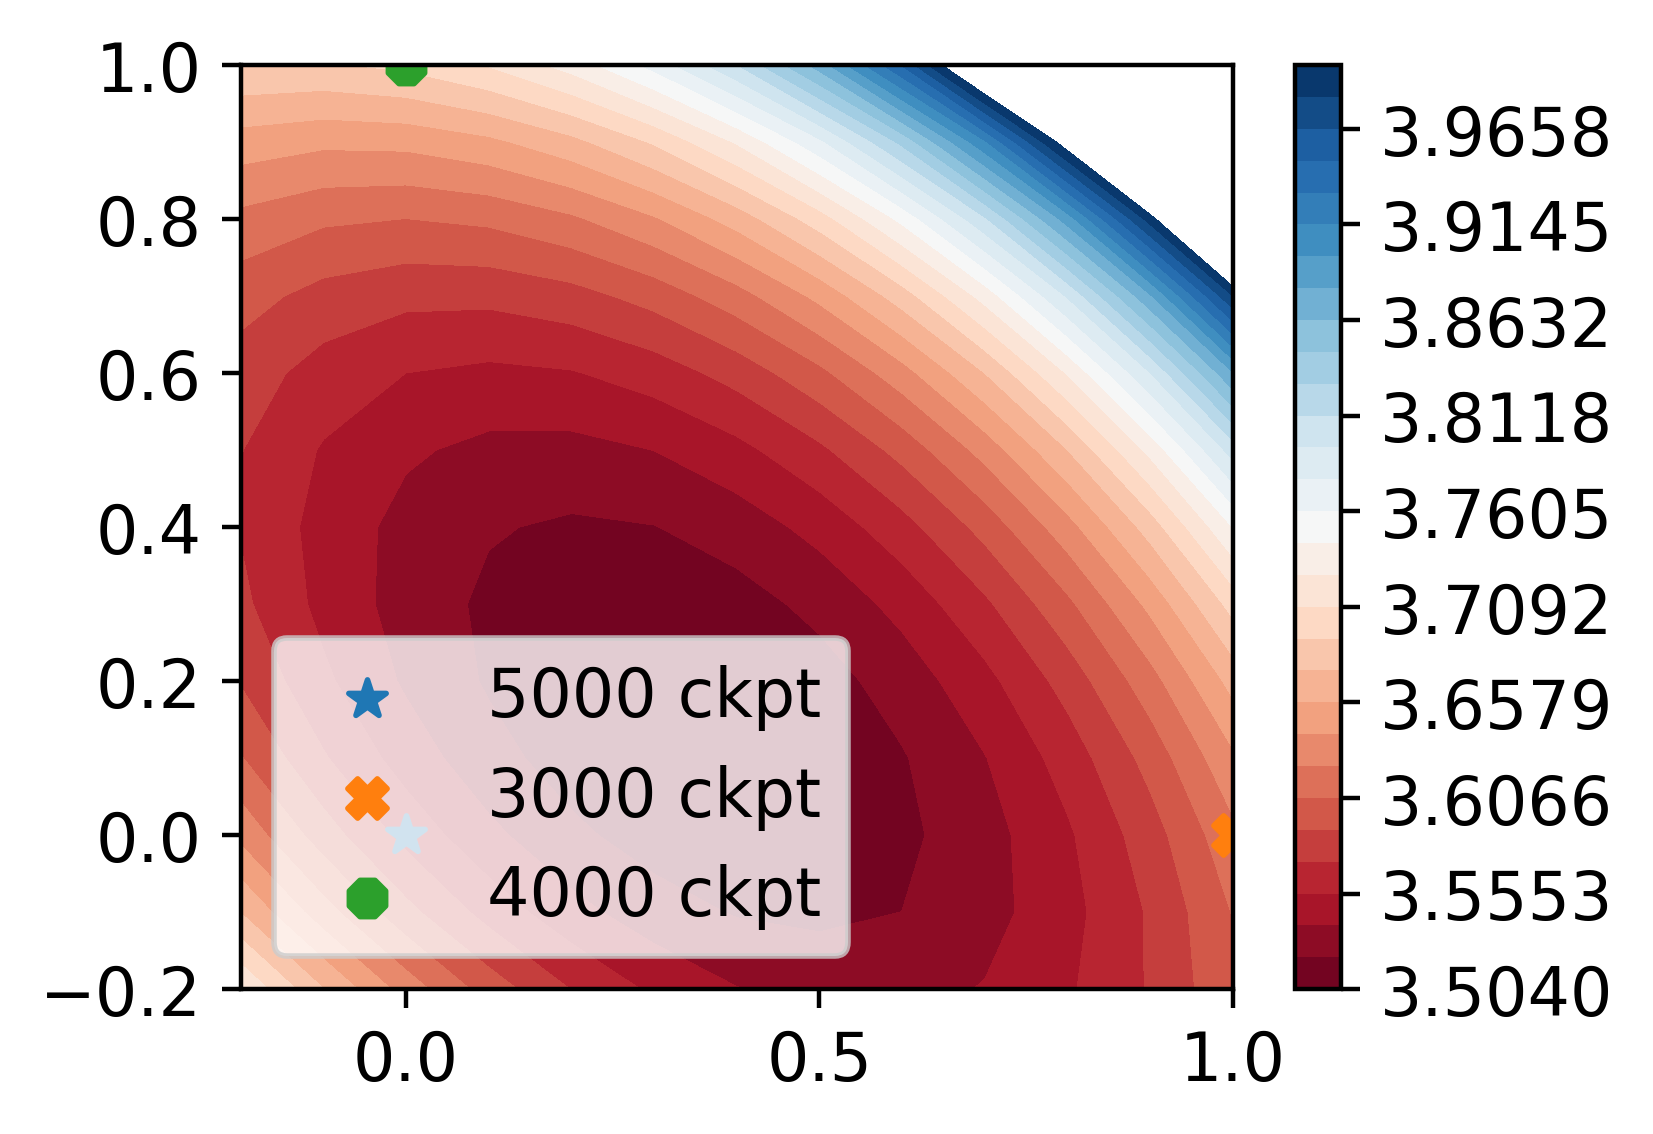

In [41]:
loss_landscape = plot_2D_landscape(3000,4000,5000)

Processing interpolation point 1/20, alpha = 0.00
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 1/20, loss = 3.70
Processing interpolation point 2/20, alpha = 0.05
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 2/20, loss = 3.67
Processing interpolation point 3/20, alpha = 0.11
/mntcephfs/lab_data/chenyu

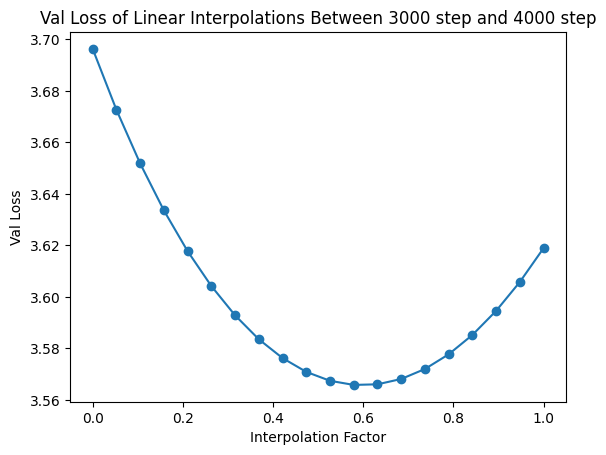

In [22]:
plot_1D_landscape(3000,4000)

Processing interpolation point 1/20, alpha = 0.00
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 1/20, loss = 3.62
Processing interpolation point 2/20, alpha = 0.05
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 2/20, loss = 3.60
Processing interpolation point 3/20, alpha = 0.11
/mntcephfs/lab_data/chenyu

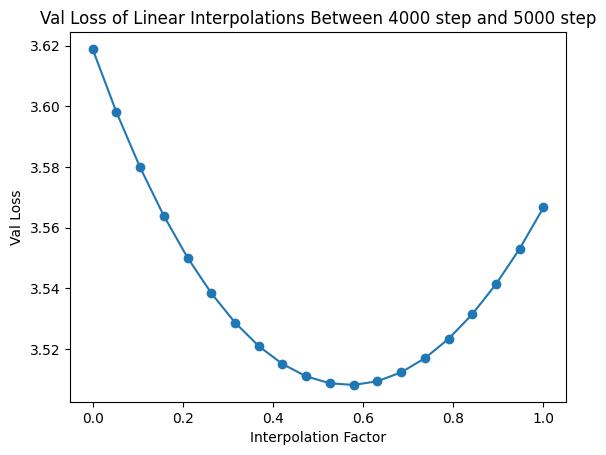

In [23]:
plot_1D_landscape(4000,5000)

Processing interpolation point 1/20, alpha = 0.00
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 1/20, loss = 3.70
Processing interpolation point 2/20, alpha = 0.05
/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563
  Processing batch 1...
  Processing batch 2...
  Processing batch 3...
  Processing batch 4...
  Processing batch 5...
  Processing batch 6...
  Processing batch 7...
  Processing batch 8...
  Processing batch 9...
  Processing batch 10...
  Completed interpolation point 2/20, loss = 3.67
Processing interpolation point 3/20, alpha = 0.11
/mntcephfs/lab_data/chenyu

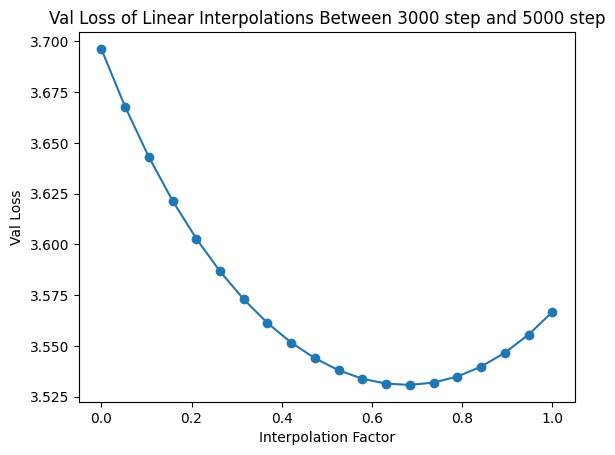

In [24]:
plot_1D_landscape(3000,5000)

In [9]:
import torch.nn.functional as F
ckpt_list = [0,100,300,900,1500,3000,6000,9000,12000,13500,14250,15000]
w_norm_collect =[]
v_collect = []
logit_collect = []
for i in range(len(ckpt_list)):
    current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{ckpt_list[i]}/main.pt",map_location=torch.device('cpu'))
    
    new_state_dict = {}
    for key, value in current_ckpt["model"].items():
        new_key = key.replace('_orig_mod.', '')  # 移除前缀
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model_weight_norm = []
    for z in model.parameters():
        model_weight_norm.append(torch.norm(z)**2)
    model_weight_norm.append(torch.norm(model.lm_head.weight)**2)
    w_norm_collect.append(model_weight_norm)

    v_norm = []
    for z in range(len(current_ckpt["optimizer"]["state"])):
        v_norm.append(torch.norm(current_ckpt["optimizer"]["state"][z]["exp_avg_sq"])**2)
    v_collect.append(v_norm)

    outputs = model(x, targets=y, get_logits=True)
    print(f"for step {ckpt_list[i]}, logits is: ", F.softmax(outputs["logits"][0,:,:], dim=-1))
    print(f"for step {ckpt_list[i]}, logits is: ", torch.norm(outputs["logits"][0,:,:], dim=-1))
    logit_collect.append(torch.norm(outputs["logits"][0,:,:], dim=-1))
    print(f"for step {ckpt_list[i]}, loss is: ", outputs["loss"])

for step 0, logits is:  tensor([[2.7410e-05, 1.7884e-05, 4.1139e-05,  ..., 2.4227e-05, 1.5727e-05,
         2.4389e-05],
        [3.0372e-05, 1.8439e-05, 3.4815e-05,  ..., 3.0668e-05, 1.2678e-05,
         2.4830e-05],
        [2.4601e-05, 2.1545e-05, 4.0151e-05,  ..., 2.4984e-05, 1.1421e-05,
         2.7087e-05],
        ...,
        [3.4903e-05, 1.8155e-05, 1.7377e-05,  ..., 1.4580e-05, 2.2837e-05,
         2.3949e-05],
        [1.7238e-05, 1.7467e-05, 2.2741e-05,  ..., 1.4490e-05, 3.1175e-05,
         1.9585e-05],
        [1.6384e-05, 2.0149e-05, 2.4723e-05,  ..., 1.5199e-05, 3.0499e-05,
         2.5895e-05]], grad_fn=<SoftmaxBackward0>)
for step 0, logits is:  tensor([88.0662, 87.5828, 87.5337, 87.3946, 87.5565, 87.7825, 87.6164, 87.5634,
        87.5097, 87.8663, 87.6542, 87.7443, 87.7915, 87.8894, 87.8965, 87.7859,
        87.9051, 87.7130, 87.9511, 87.8006, 87.8904, 87.7043, 87.9732, 87.8106,
        87.9642, 87.9899, 87.8121, 87.9318, 88.2800, 87.6485, 88.0335, 87.8102,
        

In [8]:
x, y = get_batch(data["val"], device="cpu")
#outputs = model(x, targets=y, get_logits=True)

In [88]:
import torch.nn.functional as F
F.softmax(outputs["logits"], dim=-1)

tensor([[[1.4182e-04, 2.0143e-02, 5.1584e-03,  ..., 2.3922e-09,
          2.4639e-09, 2.5268e-09],
         [7.5259e-07, 5.7496e-08, 7.2681e-07,  ..., 3.5695e-09,
          3.5798e-09, 3.5295e-09],
         [1.1424e-07, 3.7193e-08, 1.0292e-07,  ..., 7.3888e-10,
          8.0217e-10, 7.7085e-10],
         ...,
         [9.0310e-05, 1.0836e-06, 3.3114e-07,  ..., 2.3105e-09,
          2.4500e-09, 2.3787e-09],
         [2.1500e-05, 9.3098e-08, 1.5636e-06,  ..., 8.0264e-10,
          7.7911e-10, 8.1104e-10],
         [3.3998e-02, 4.8093e-05, 3.7853e-06,  ..., 1.7680e-10,
          1.5927e-10, 1.7048e-10]],

        [[3.1804e-04, 5.0189e-04, 7.1118e-06,  ..., 3.3506e-09,
          3.2624e-09, 3.2419e-09],
         [1.4177e-05, 2.8259e-05, 9.0759e-07,  ..., 1.9377e-08,
          1.9363e-08, 1.9928e-08],
         [2.5425e-03, 1.9589e-03, 9.1875e-07,  ..., 1.2084e-09,
          1.2310e-09, 1.1925e-09],
         ...,
         [3.4397e-06, 4.0269e-06, 7.6405e-07,  ..., 6.1740e-09,
          6.103

tensor([[  198,   220,   220,  ...,   287,   262,  1956],
        [  319,   262,  1080,  ...,    11, 27635,    11],
        [ 1989,    11,   355,  ...,   761,   284,  1414],
        ...,
        [  290, 15995,  8821,  ...,   284,  8006,   351],
        [ 7464,   290,   262,  ..., 32350,   416,  1793],
        [ 2836,  7071,   290,  ...,   373,  6655,   379]])

In [36]:
v_collect = torch.tensor(v_collect[1:])

In [28]:
torch.norm(current_ckpt["optimizer"]["state"][3]["exp_avg_sq"])**2

tensor(2.4767e-11)

In [42]:
w_norm_collect = torch.tensor(w_norm_collect)
v_collect = torch.tensor(v_collect)

/tmp/ipykernel_2953609/3997711065.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_collect = torch.tensor(v_collect)


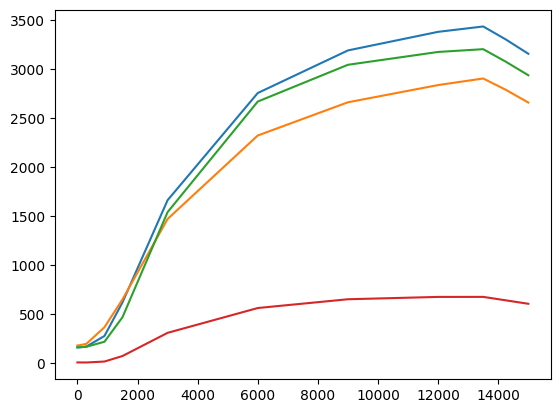

In [52]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot(ckpt_list,w_norm_collect[:,40],label="0")
plt.plot(ckpt_list,w_norm_collect[:,30],label="0")
plt.plot(ckpt_list,w_norm_collect[:,20],label="0")
plt.plot(ckpt_list,w_norm_collect[:,10],label="0")
#plt.yscale("log")
plt.show()

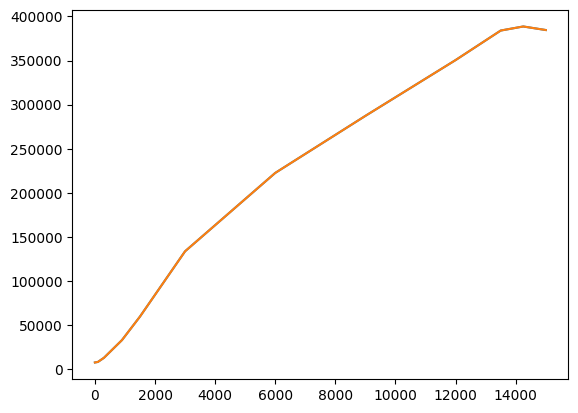

In [55]:
plt.plot(ckpt_list,w_norm_collect[:,-1],label="0")
plt.plot(ckpt_list,w_norm_collect[:,0],label="1")

tensor(7709.9512)

In [62]:
w_norm_collect[-1,-1]

tensor(384608.3750)

In [59]:
model.lm_head.weight

Parameter containing:
tensor([[ 0.0043, -0.0641, -0.1759,  ...,  0.1111,  0.1219,  0.1505],
        [-0.2183, -0.2114, -0.0254,  ..., -0.0847, -0.0113,  0.3778],
        [-0.2328, -0.0040,  0.0153,  ...,  0.1681, -0.1120, -0.0272],
        ...,
        [ 0.0419, -0.0125,  0.0464,  ...,  0.0769,  0.0128, -0.1543],
        [ 0.0303, -0.0160,  0.0545,  ...,  0.0826,  0.0090, -0.1510],
        [ 0.0271, -0.0170,  0.0534,  ...,  0.0826,  0.0077, -0.1486]],
       requires_grad=True)

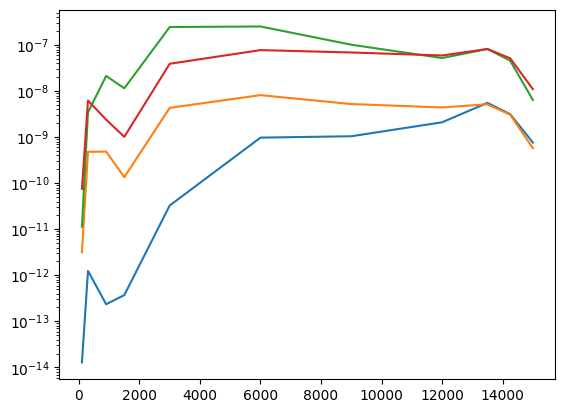

In [48]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")
plt.plot(ckpt_list[1:],v_collect[:,40],label="0")
plt.plot(ckpt_list[1:],v_collect[:,30],label="0")
plt.plot(ckpt_list[1:],v_collect[:,20],label="0")
plt.plot(ckpt_list[1:],v_collect[:,10],label="0")
plt.yscale("log")
plt.show()

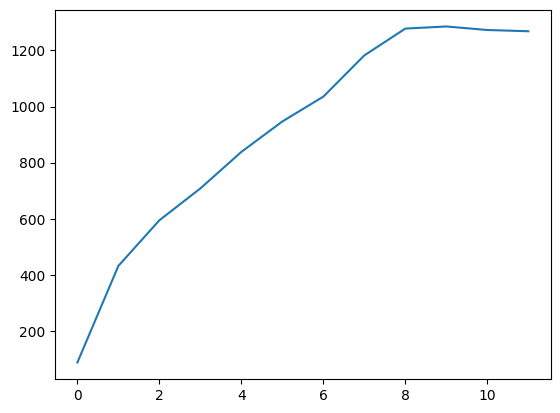

In [12]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot([torch.mean(i).detach().cpu().float() for i in logit_collect])
plt.show()

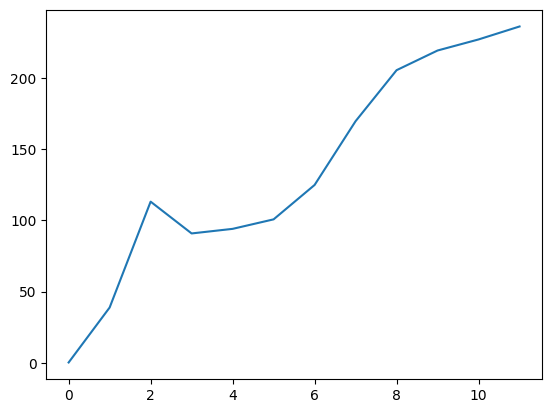

In [13]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot([torch.std(i).detach().cpu().float() for i in logit_collect])
plt.show()

In [28]:
torch.mean(logit_collect[0].cpu().detach()).float()

tensor(7679.3281)

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x15545188c860> (for post_run_cell), with arguments args (<ExecutionResult object at 15545e150e10, execution_count=28 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 15545e13f890, raw_cell="torch.mean(logit_collect[0].cpu().detach()).float(.." store_history=True silent=False shell_futures=True cell_id=2b7aaf5a-dcb9-4a1f-9bde-e919459ffd06> result=tensor(7679.3281)>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [12]:
ckpt= torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/9000/main.pt", map_location=torch.device('cpu'))

In [14]:
model.load_state_dict(ckpt)

RuntimeError: Error(s) in loading state_dict for Llama:
	Missing key(s) in state_dict: "transformer.wte.weight", "transformer.h.0.ln_1.weight", "transformer.h.0.attn.c_attn.weight", "transformer.h.0.attn.c_proj.weight", "transformer.h.0.ln_2.weight", "transformer.h.0.mlp.w1.weight", "transformer.h.0.mlp.w2.weight", "transformer.h.0.mlp.c_proj.weight", "transformer.h.1.ln_1.weight", "transformer.h.1.attn.c_attn.weight", "transformer.h.1.attn.c_proj.weight", "transformer.h.1.ln_2.weight", "transformer.h.1.mlp.w1.weight", "transformer.h.1.mlp.w2.weight", "transformer.h.1.mlp.c_proj.weight", "transformer.h.2.ln_1.weight", "transformer.h.2.attn.c_attn.weight", "transformer.h.2.attn.c_proj.weight", "transformer.h.2.ln_2.weight", "transformer.h.2.mlp.w1.weight", "transformer.h.2.mlp.w2.weight", "transformer.h.2.mlp.c_proj.weight", "transformer.h.3.ln_1.weight", "transformer.h.3.attn.c_attn.weight", "transformer.h.3.attn.c_proj.weight", "transformer.h.3.ln_2.weight", "transformer.h.3.mlp.w1.weight", "transformer.h.3.mlp.w2.weight", "transformer.h.3.mlp.c_proj.weight", "transformer.h.4.ln_1.weight", "transformer.h.4.attn.c_attn.weight", "transformer.h.4.attn.c_proj.weight", "transformer.h.4.ln_2.weight", "transformer.h.4.mlp.w1.weight", "transformer.h.4.mlp.w2.weight", "transformer.h.4.mlp.c_proj.weight", "transformer.h.5.ln_1.weight", "transformer.h.5.attn.c_attn.weight", "transformer.h.5.attn.c_proj.weight", "transformer.h.5.ln_2.weight", "transformer.h.5.mlp.w1.weight", "transformer.h.5.mlp.w2.weight", "transformer.h.5.mlp.c_proj.weight", "transformer.h.6.ln_1.weight", "transformer.h.6.attn.c_attn.weight", "transformer.h.6.attn.c_proj.weight", "transformer.h.6.ln_2.weight", "transformer.h.6.mlp.w1.weight", "transformer.h.6.mlp.w2.weight", "transformer.h.6.mlp.c_proj.weight", "transformer.h.7.ln_1.weight", "transformer.h.7.attn.c_attn.weight", "transformer.h.7.attn.c_proj.weight", "transformer.h.7.ln_2.weight", "transformer.h.7.mlp.w1.weight", "transformer.h.7.mlp.w2.weight", "transformer.h.7.mlp.c_proj.weight", "transformer.ln_f.weight", "lm_head.weight". 
	Unexpected key(s) in state_dict: "model", "optimizer", "scheduler", "itr". 

In [32]:
len(ckpt["optimizer"]["state"])
#[0]["exp_avg_sq"]

58

In [18]:
ckpt["model"]

OrderedDict([('_orig_mod.transformer.wte.weight',
              tensor([[ 0.0380, -0.0416, -0.1583,  ...,  0.0875,  0.1105,  0.1353],
                      [-0.1869, -0.1619, -0.0191,  ..., -0.0474, -0.0114,  0.3042],
                      [-0.1679,  0.0023,  0.0321,  ...,  0.0980, -0.1377, -0.0164],
                      ...,
                      [ 0.0686,  0.0264,  0.0315,  ...,  0.0914,  0.0550, -0.1859],
                      [ 0.0550,  0.0226,  0.0417,  ...,  0.0992,  0.0517, -0.1839],
                      [ 0.0521,  0.0226,  0.0393,  ...,  0.0985,  0.0499, -0.1796]])),
             ('_orig_mod.transformer.h.0.ln_1.weight',
              tensor([0.0771, 0.1140, 0.0732, 0.0778, 0.1468, 0.0677, 0.0819, 0.0725, 0.1877,
                      0.0624, 0.0599, 0.0842, 0.0735, 0.2298, 0.0524, 0.1138, 0.0569, 0.0774,
                      0.1038, 0.0722, 0.0657, 0.0549, 0.0806, 0.0530, 0.0609, 0.0564, 0.1025,
                      0.1490, 0.0783, 0.0676, 0.0576, 0.1265, 0.0792, 0.0619, 0

In [21]:
z = 0
for i in model.parameters():
    z+=1
z

58

In [26]:
for n,p in model.named_parameters():
    print(n)

transformer.wte.weight
transformer.h.0.ln_1.weight
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_proj.weight
transformer.h.0.ln_2.weight
transformer.h.0.mlp.w1.weight
transformer.h.0.mlp.w2.weight
transformer.h.0.mlp.c_proj.weight
transformer.h.1.ln_1.weight
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_proj.weight
transformer.h.1.ln_2.weight
transformer.h.1.mlp.w1.weight
transformer.h.1.mlp.w2.weight
transformer.h.1.mlp.c_proj.weight
transformer.h.2.ln_1.weight
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_proj.weight
transformer.h.2.ln_2.weight
transformer.h.2.mlp.w1.weight
transformer.h.2.mlp.w2.weight
transformer.h.2.mlp.c_proj.weight
transformer.h.3.ln_1.weight
transformer.h.3.attn.c_attn.weight
transformer.h.3.attn.c_proj.weight
transformer.h.3.ln_2.weight
transformer.h.3.mlp.w1.weight
transformer.h.3.mlp.w2.weight
transformer.h.3.mlp.c_proj.weight
transformer.h.4.ln_1.weight
transformer.h.4.attn.c_attn.weight
transformer.h.4.attn.c_proj.weight